<a href="https://colab.research.google.com/github/21holden21/Analyzing-Cricket-Songs-with-Machine-Learning/blob/main/Cricket_Song_Analysis_and_Classification_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup/Loading the Audio Files into Waveforms/High Pass Filter Used for Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa #to extract audio features from raw audio .wav files
import numpy as np #for matrix manipulations
import os #to locate files
import random #for splitting data into training/validation sets
from scipy import signal #to filter signals

In [ ]:
##Loading the cricket audio .wav files into waveform list
wav_dir = "/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/.wav Files/"

waveform_list = []
num_iter = 0

cricket_names = [] ##use parallel array to keep track of cricket name for each audio file

for wav_file in sorted(os.listdir(wav_dir)):  
  num_iter += 1
  print("ITERATION NUMBER: ", str(num_iter))

  if wav_file.find("Xenogryllus") != -1 and wav_file.find("(MCL)") != -1: ##Xenogryllus MCL files (no species name) assumed to be Xenogryllus uniparitus species
     cricket_names.append("Xenogryllus" + " " + "unipartitus" +  " " + "MCL")
  else:
     split_file = wav_file.split(" ")
     if wav_file.find("MCL") != -1: ##if file is from MCL
      cricket_names.append(split_file[0] + " " + split_file[1] + " " + "MCL")
     else: ##if file is from SINA
      cricket_names.append(split_file[0] + " " + split_file[1] + " " + "SINA")
      
  #create waveform from .wav file
  waveform, sr = librosa.load(wav_dir + wav_file)
  waveform_list.append(waveform)

In [ ]:
cricket_names

In [19]:
##high pass filter to get rid of low frequencies
from scipy import signal
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Model Architectures -- LeNet-5 and SCNNB

In [29]:
##functions used from keras/tensorflow to create our models
import keras
from keras import callbacks ##used to stop training model when best (lowest) loss values have been achieved
from keras.callbacks import EarlyStopping ##used to stop training model when best (lowest) loss values have been achieved
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout ##these are the different types of layers the models employ
from tensorflow.keras.utils import to_categorical ##convert class list to binary class matrix 
                                                  ##(i.e. [0,1,2] --> [ [1,0,0], [0,1,0], [0,0,1]]
                                                  ##necessary for obtaining true class value when training

In [30]:
def LeNet5(input_shape, classes): ##feel free to tune the model parameters
  model = keras.Sequential()

  model.add(Conv2D(filters=6, kernel_size=(3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3)))
  model.add(Activation('relu'))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=60, activation='relu'))

  model.add(Dense(units=42, activation='relu'))

  model.add(Dense(units=classes, activation = 'softmax'))
  
  return model

In [31]:
#another shallow, efficient CNN
def SCNNB(input_shape, classes): ##feel free to tune the model parameters
  model = keras.Sequential()

  model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters=32, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(units=640, activation='relu'))
  model.add(Dropout(0.25)) #dropout seeks to prevent overfitting and attempts to train the model faster -- feel free to play around with this percentage

  model.add(Dense(units=classes, activation = 'softmax'))
  
  return model

# Information on \# of Files per Genus

In [ ]:
##first, get information on how many files per genus and species
genus_dict = {}

for name in cricket_names:
    #name = "Genus species MCL" or "Genus species SINA"
    genus_name = name.split(" ")[0]
        
    if genus_name in genus_dict: #have already seen genus, increment counter by 1
        genus_dict[genus_name] += 1
    else: #haven't seen this genus yet
        genus_dict[genus_name] = 1

In [ ]:
genus_dict

{'Acheta': 5,
 'Allonemobius': 41,
 'Anaxipha': 34,
 'Antillicharis': 3,
 'Anurogryllus': 2,
 'Cycloptilum': 72,
 'Cyrtoxipha': 17,
 'Eunemobius': 15,
 'Gryllita': 1,
 'Gryllodes': 1,
 'Gryllotalpa': 8,
 'Gryllus': 72,
 'Hapithus': 11,
 'Hoplosphyrum': 4,
 'Hygronemobius': 5,
 'Miogryllus': 4,
 'Neocurtilla': 6,
 'Neonemobius': 16,
 'Neoscapteriscus': 2,
 'Neoxabea': 5,
 'Oecanthus': 62,
 'Orocharis': 21,
 'Phyllopalpus': 5,
 'Pictonemobius': 13,
 'Velarifictorus': 5,
 'Xenogryllus': 4}

In [ ]:
min_genus_count = 30 ##min file count for a particular genus to be considered as a class for the model

# Genus Classification Model that Uses 1 Sample Per Audio File

## Mel spectrograms are used as input

In [ ]:
##generate mel specs for genus classification: output --> numerical matrix, which is added to the dataset used for training
num_iter = 0

audio_length = librosa.time_to_frames(5) #take only 5 seconds from melspectrograms
num_mel_bands = 128

mel_spec_list = []

for waveform in waveform_list: ##go through waveforms for each of the audio files and create a mel spectrogram from them

  print("ITERATION NUMBER: ", str(num_iter+1))

  mel_spec = librosa.feature.melspectrogram(butter_highpass_filter(waveform, 2000, sr), sr=sr) #build mel spec for the entire (filtered) waveform (2000 is second arg to drop all frequencies below 2KHz)
  log_mel_spec = librosa.power_to_db(mel_spec) ##convert power to log scale to perceptually represent intensity of the sound
  num_frames = mel_spec.shape[1] #number of frames for particular file

  if cricket_names[num_iter].find("SINA") != -1: #SINA: take first 5 seconds from mel spectrogram (no voiceover at the beginning)

      if num_frames >= audio_length:
        mel_spec_list.append(log_mel_spec[:,0:audio_length])

      else: #file less than 5 seconds
        pass #disregard because we'd have to 0 pad, which could affect how well the data clusters in the t-sne plot
        
  else: #MCL --> take seconds 5.2-10.2 from mel spectrogram (voiceover of roughly 5 seconds at beginning)
      jump_about_5_seconds = librosa.time_to_frames(5.2) ##jump a tad bit over 5 seconds to not get voiceover data
      if num_frames >= audio_length+jump_about_5_seconds: 
        mel_spec_list.append(log_mel_spec[:,jump_about_5_seconds:audio_length+jump_about_5_seconds])
      else: #file less than 10.2 seconds
        pass #disregard because we'd have to 0 pad, which could affect how well the data clusters in the t-sne plot
      

  num_iter += 1

mel_spec_list = np.array(mel_spec_list)
print(mel_spec_list.shape)

In [ ]:
##filter out all files in the dataset belonging to a genus with < 30 files
filter_array = []
for i in range(len(mel_spec_list)):
  genus_name = cricket_names[i].split(" ")[0]
  if genus_dict[genus_name] >= min_genus_count:
    filter_array.append(True)
  else:
    filter_array.append(False)

mel_spec_list = mel_spec_list[filter_array]

In [ ]:
mel_spec_list.shape

(281, 128, 215)

In [ ]:
#creating classification list (classifies the mel spec for a specific file as belonging to a certain genus)
genus_classification = []
class_num = 0 #will be used as an id for each genus with >= 30 files
for key, value in genus_dict.items(): #genus dictionary is in alphabetical order just like the mel_spec_list
    if genus_dict[key] >= min_genus_count: ##pass over genera with < 30 files
        for i in range(genus_dict[key]): #duplicate the same genus class_num and append to end of genus_classification list for as many files there are for that genus 
            genus_classification.append(class_num)
        class_num += 1
print(len(genus_classification))

281


In [ ]:
data_set = []
for i in range(len(mel_spec_list)):
  data_set.append([mel_spec_list[i], genus_classification[i]]) ##each point of the dataset for training must have an x (the input/mel spectrogram) and a y (the output/genus class)

In [ ]:
##randomly assign data to training/validation set
pre_training_set = []
pre_validation_set = []
training_percentage = 0.80
validation_percentage = 0.20
offset = 0 ##keeps track of how many genera samples we have "jumped over"
for i in ["Allonemobius", "Anaxipha", "Cycloptilum", "Gryllus", "Oecanthus"]: ##shuffle data for each class separately and assign to training/validation so that one class's data doesn't accidentally all end up in validation set
                                                                              ##shuffling separately guarantees each class has 80% of its data in the training set (we have a relatively small dataset)
    arr_for_single_class = data_set[offset:offset + genus_dict[i]] ##the number of datapoints belonging to a specific genera = genus_dict[i]
    random.shuffle(arr_for_single_class) 
    num_training_for_one_class = int(training_percentage * genus_dict[i])
    pre_training_set += arr_for_single_class[:num_training_for_one_class]
    pre_validation_set += arr_for_single_class[num_training_for_one_class:] ##append remaining samples to validation set (should be roughly 20%)
    offset += genus_dict[i]

print(len(pre_training_set))
print(len(pre_validation_set))

222
59


In [ ]:
##separate the x and y for each sample in the dataset
x_train = []
y_train = []

x_validation = []
y_validation = []

for i in range(len(pre_training_set)):
    x_train.append(pre_training_set[i][0])
    y_train.append(pre_training_set[i][1])

for i in range(len(pre_validation_set)):
    x_validation.append(pre_validation_set[i][0])
    y_validation.append(pre_validation_set[i][1])

print(x_train[0].shape)
print(y_train)
print(y_validation)

(128, 215)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
##reshape to create size 1 channel for CNN model input
for i in range(len(x_train)):
  x_train[i] = x_train[i].reshape((128, 215, 1))

In [ ]:
##LeNet5 (80% for training)
num_genuses = 5 #because we have 5 genera with >= 30 files
model = LeNet5(input_shape = (128, 215, 1), classes = num_genuses)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_genuses), epochs = 25, batch_size = int(0.1 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_genuses)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/lenet genus 1 sample per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_genuses))

2/2 [==============================] - 0s 89ms/step - loss: 0.6660 - accuracy: 0.7458


[0.6660054326057434, 0.7457627058029175]

In [ ]:
##SCNNB (80% for training)
num_genuses = 5 #because we have 5 genera with >= 30 files
model = SCNNB(input_shape = (128, 215, 1), classes = num_genuses)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_genuses), epochs = 50, batch_size = int(0.1 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_genuses)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/scnnb genus 1 sample per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_genuses))

2/2 [==============================] - 0s 127ms/step - loss: 2.2013 - accuracy: 0.7288


[2.2012877464294434, 0.7288135886192322]

# Genus classification Model that Uses 8 Samples Per Audio File

## Mel spectrograms are used as input

In [ ]:
###USING SLIDING WINDOW/MAKING MORE SAMPLES FROM ROUGHLY SAME AMOUNT OF AUDIO FILES

In [ ]:
#filter waveforms that have at least 10 sec of audio and in genus with >= 30 files
filtered_waveforms = []
filtered_cricket_names = []
num_iter = 0
for waveform in waveform_list:
  genus_name = cricket_names[num_iter].split(" ")[0] #cricket_names[num_iter] = "Genus species MCL" or "Genus species SINA"
  if librosa.get_duration(waveform) >= 15 and cricket_names[num_iter].find("MCL") != -1 and genus_dict[genus_name] > min_genus_count: ##MCL files have 5 second voice over at beginning, so the files need to be at least 15 sec long
    filtered_waveforms.append(waveform)
    filtered_cricket_names.append(cricket_names[num_iter])
  elif librosa.get_duration(waveform) >= 10 and cricket_names[num_iter].find("SINA") != -1 and genus_dict[genus_name] > min_genus_count: ##SINA files don't have 5 second voiceover at beginning, just needs to be 10 sec long
    filtered_waveforms.append(waveform)
    filtered_cricket_names.append(cricket_names[num_iter])
  num_iter += 1

In [ ]:
len(filtered_waveforms)

262

In [ ]:
#creating mel specs from filtered waveform data

filtered_mel_spec_data = []

sample_length = librosa.time_to_frames(3) #3 secs --> each sample in the dataset will be 3 seconds long
hop_length = librosa.time_to_frames(1) #1 secs --> adjacent samples overlap in 2 seconds (helps with shift invariance)
num_mel_bands = 128

num_iter = 0
for waveform in filtered_waveforms:

    print("ITERATION NUMBER: ", str(num_iter+1))

    ##extract mel spectrogram for the entire (filtered) waveform
    mel_spec = librosa.feature.melspectrogram(butter_highpass_filter(waveform, 2000, sr), sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec)


    if filtered_cricket_names[num_iter].find("SINA") != -1: #take first 10 seconds from SINA data
        start_pos = 0
        for i in range(8): ##extract 8, 3 second segments from 10 second segment with 1 second hop size
            filtered_mel_spec_data.append(log_mel_spec[:,start_pos:start_pos + sample_length])
            start_pos += hop_length

    else: ##Macaulay library data
        start_pos = librosa.time_to_frames(5.5) #skip first 5.5 seconds due to voice over at beginning
        for i in range(8):  ##extract 8, 3 second segments from 10 second segment with 1 second hop size
            filtered_mel_spec_data.append(log_mel_spec[:,start_pos:start_pos + sample_length])
            start_pos += hop_length

    num_iter += 1

In [ ]:
##get information on how many files per genus AFTER  files were cut for length --> this recreation of the genus dict is necessary when creating the classification list since some of the files for a genus with >= 30 files could've been removed because it didn't have 10 seconds of meaningful data
genus_dict = {}

for name in filtered_cricket_names:
    genus_name = name.split(" ")[0]
        
    if genus_name in genus_dict: #have already seen genus, increment counter by 1
        genus_dict[genus_name] += 1
    else: #haven't seen this genus yet
        genus_dict[genus_name] = 1

In [ ]:
genus_dict

{'Allonemobius': 37,
 'Anaxipha': 33,
 'Cycloptilum': 65,
 'Gryllus': 69,
 'Oecanthus': 58}

In [ ]:
#creating classification list (classifies the mel spec for a specific file as belonging to a certain genus)
genus_classification = []
class_num = 0 #will be used as an id for each genus with >= 30 files
for key, value in genus_dict.items(): #genus dictionary is in alphabetical order just like the mel_spec_list
      print(key, value)
      for i in range(8*genus_dict[key]): #duplicate the same genus class_num and append to end of genus_classification list for as many files there are for that genus mutiplied by 8 (since there are 8 samples per file)
          genus_classification.append(class_num)
      class_num += 1
print(len(genus_classification))

Allonemobius 37
Anaxipha 33
Cycloptilum 65
Gryllus 69
Oecanthus 58
2096


In [ ]:
data_set = []
for i in range(len(filtered_mel_spec_data)):
  data_set.append([filtered_mel_spec_data[i], genus_classification[i]]) ##each point of the dataset for training must have an x (the input/mel spectrogram) and a y (the output/genus class)

In [ ]:
len(data_set)

2096

In [ ]:
##randomly shuffle x_data based on genus classification to randomly assign data to training/validation set
pre_training_set = []
pre_validation_set = []
training_percentage = 0.80
validation_percentage = 0.20
offset = 0 ##keeps track of how many genera we have "jumped over"
for i in ["Allonemobius", "Anaxipha", "Cycloptilum", "Gryllus", "Oecanthus"]:##shuffle data for each class separately and assign to training/validation so that one class's data doesn't accidentally all end up in validation set
                                                                             ##shuffling separately guarantees each class has 80% of its data in the training set (we have a relatively small dataset)
    arr_for_single_class = data_set[offset:offset + 8*genus_dict[i]] 
    random.shuffle(arr_for_single_class)
    num_training_for_one_class = int(training_percentage * 8*genus_dict[i]) ##the number of samples belonging to a specific genera = 8*genus_dict[i]
    pre_training_set += arr_for_single_class[:num_training_for_one_class]
    pre_validation_set += arr_for_single_class[num_training_for_one_class:]  ##append remaining samples to validation set (should be roughly 20%)
    offset += 8*genus_dict[i]

print(len(pre_training_set))
print(len(pre_validation_set))

1675
421


In [ ]:
##separate the x and y for each sample in the dataset
x_train = []
y_train = []

x_validation = []
y_validation = []

for i in range(len(pre_training_set)):
    x_train.append(pre_training_set[i][0])
    y_train.append(pre_training_set[i][1])

for i in range(len(pre_validation_set)):
    x_validation.append(pre_validation_set[i][0])
    y_validation.append(pre_validation_set[i][1])

print(x_train[1].shape)
print(y_train)
print(y_validation)

(128, 129)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
##reshape to create size 1 channel for CNN model input
for i in range(len(x_train)):
  x_train[i] = x_train[i].reshape((128, 129, 1))

In [ ]:
x_train[0].shape

(128, 129, 1)

In [ ]:
##LeNet5 (80% for training)
num_genuses = 5 #because we have 5 genera with >= 30 files
model = LeNet5(input_shape = (128, 129, 1), classes = num_genuses)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_genuses), epochs = 50, batch_size = int(0.1 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_genuses)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/lenet genus 8 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_genuses))

14/14 [==============================] - 1s 44ms/step - loss: 0.2173 - accuracy: 0.9169


[0.21730472147464752, 0.9168646335601807]

In [ ]:
##SCNNB (80% for training)
num_genuses = 5 #because we have 5 genera with >= 30 files
model = SCNNB(input_shape = (128, 129, 1), classes = num_genuses)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_genuses), epochs = 100, batch_size = int(0.1 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_genuses)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/scnnb genus 8 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_genuses))

14/14 [==============================] - 1s 75ms/step - loss: 0.1161 - accuracy: 0.9644


[0.11613507568836212, 0.9643705487251282]

# Loading Dataset that Contains 607 Species Files in the Gryllus Genus

In [ ]:
##Loading the new .wav file data into waveform list (ALL SPECIES ARE THE GRYLLUS GENUS)
wav_dir = "/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/species in gryllus genus .wav files/"

data = []
waveform_list = []
cricket_names = []

num_iter = 0

print(len(os.listdir(wav_dir))) ##there are 607 species in the Gryllus genus for this dataset

for wav_file in sorted(os.listdir(wav_dir)):   ##there's a ton of alphanumeric characters at the beginning of the file names, so the directory sorted by file name doesn't sort by the actual species name, as it did for the SINA/MCL joint dataset
  print("ITERATION NUMBER: ", str(num_iter+1))

  #create waveform data for file
  waveform, sr = librosa.load(wav_dir + wav_file)

  #create cricket name from wav_file name
  id = num_iter #allows us to go back an locate exact species file
  text_after_G = wav_file.split("G. ")[1] #text_after_G = "{species_name}.wav" in the case of a non-firmus file and "firmus TX.wav" or "firmus FL.wav" in the case of a firmus file
  species = text_after_G.split(" ")[0]  ##need to split by space because the firmus files are named as "firmus TX.wav" or "firmus FL.wav" --> need to get rid of "TX.wav"/"FL.wav" part after space to get the species name
  if species.find(".wav") != -1 or species.find(".WAV") != -1: #for non-firmus files, the species variable will contain "{species_name}.wav" or "{species_name}.WAV" --> need to take off the .wav/.WAV part
    species = species[:-4]

  #zip 2 data entities for sorting later on
  data.append((waveform, species + " " + str(id)))

  num_iter += 1

data.sort(key=lambda elem: elem[1]) ##sorts first by species name, then by RXX-XXX_XXXXXX alphanumeric characters (the id given to each file is based on the sorted position of its RXX-XXX_XXXXXX alphanumeric characters)

waveform_list = [i for (i,j) in data]
cricket_names = [j for (i,j) in data]

print(len(waveform_list))
print(len(cricket_names))
print(cricket_names)

In [8]:
#this code maps the file name to what we stored as the file's species name (remember, the species name is "{species_name} {id}") just so that you can see what file each species name belongs to
#this code is really just for understanding purposes, this mapping scheme isn't ever used for data analysis
num_iter = 0
file_to_name = {}
for wav_file in sorted(os.listdir(wav_dir)):

  #create cricket name from wav_file name
  id = num_iter #allows us to go back an locate exact species file
  text_after_G = wav_file.split("G. ")[1] #text_after_G = "{species_name}.wav" in the case of a non-firmus file and "firmus TX.wav" or "firmus FL.wav" in the case of a firmus file
  species = text_after_G.split(" ")[0] ##need to split by space because the firmus files are named as "firmus TX.wav" or "firmus FL.wav" --> need to get rid of "TX.wav"/"FL.wav" part after space to get the species name
  if species.find(".wav") != -1 or species.find(".WAV") != -1: #for non-firmus files, the species variable will contain "{species_name}.wav" or "{species_name}.WAV" --> need to take off the .wav/.WAV part
    species = species[:-4]

  species += " " + str(id)
  file_to_name[wav_file] = species

  num_iter += 1

In [ ]:
file_to_name

# Understanding the Time Duration Distribution of the Species in the Gryllus Genus Files

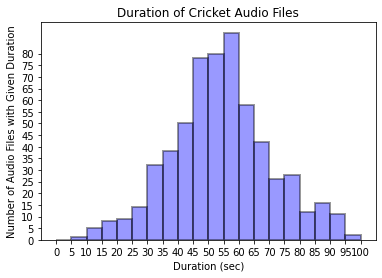

In [10]:
##looking at time duration distribution for input wav files
import matplotlib.pyplot as plt ##to plot the histogram

wav_dir = "/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/species in gryllus genus .wav files/"
duration_list = [] ##stores length of each audio file

for wav_file in sorted(os.listdir(wav_dir)):
    wav_file_duration = librosa.get_duration(filename=wav_dir + wav_file)
    wav_file_duration -= 5.5 ##some of the files have a voiceover in the first 5 seconds -- we will just not use the first 5 seconds for any of the audio files when constructing the mel spectrograms to avoid any of the samples containing voice overs instead of actual cricket songs
    duration_list.append(wav_file_duration)

##create histogram
fig,ax = plt.subplots(1,1)
a = np.array(duration_list)
ax.hist(a, range = (0, 100), bins = 20, color="blue", alpha=0.4,edgecolor ="black", linewidth=2) ##only display audio files <= 100 seconds (we just need to hone in on smaller files, which might need to be cut because the don't have enough meaningful audio)
                                                                                                 ##put audio files in same bin if their lengths are within 5 seconds of each other
ax.set_xticks(range(0,105,5))##x axis = file length
ax.set_yticks(range(0,85,5)) ##y axis = count of files with a file length in a certain range
ax.set_xlabel("Duration (sec)")
ax.set_ylabel("Number of Audio Files with Given Duration")
ax.set_title("Duration of Cricket Audio Files")
plt.show()



# Species Classification Model that Uses 8 Samples Per Audio File

## Mel spectrograms are used as input

In [ ]:
###USING SLIDING WINDOW/MAKING MORE SAMPLES FROM ROUGHLY SAME AMOUNT OF AUDIO FILES

In [11]:
#filter waveforms that have at least 10 sec of meaningful (non voice over) audio
filtered_waveforms = []
filtered_cricket_names = []
num_iter = 0
for waveform in waveform_list:
  if librosa.get_duration(waveform) - 5.5 >= 10: #remove 5 seconds from waveform file due to possible voice over at beginning
    filtered_waveforms.append(waveform)
    filtered_cricket_names.append(cricket_names[num_iter])
  num_iter += 1

In [12]:
print(len(filtered_waveforms))
print(len(filtered_cricket_names))

606
606


In [13]:
##get information on how many files per species for Gryllus genus data after removing files with less than 10 seconds of meaningful data
species_dict = {}

for name in filtered_cricket_names:
    species_name = name.split(" ")[0] #name = "{species_name} {id}"
    if species_name in species_dict: #have already seen genus, increment counter by 1
        species_dict[species_name] += 1
    else: #haven't seen this genus yet
        species_dict[species_name] = 1

In [14]:
species_dict

{'armatus': 88,
 'assimilis': 34,
 'brevicaudus': 9,
 'chisosensis': 2,
 'cohni': 18,
 'firmus': 69,
 'fultoni': 20,
 'integer': 54,
 'leei': 34,
 'lightfooti': 198,
 'lineaticeps': 80}

In [15]:
#filter remaining waveforms that are a species with at least 15 files
final_waveforms = []
final_cricket_names = []
num_iter = 0
for waveform in filtered_waveforms:
  if species_dict[filtered_cricket_names[num_iter].split(" ")[0]] >= 15:
    final_waveforms.append(waveform)
    final_cricket_names.append(filtered_cricket_names[num_iter])
  num_iter += 1

In [16]:
print(len(final_waveforms))
print(len(final_cricket_names))

595
595


In [ ]:
#creating mel specs from filtered waveform data

filtered_mel_spec_data = []

sample_length = librosa.time_to_frames(3) #3 secs --> each sample in the dataset will be 3 seconds long
hop_length = librosa.time_to_frames(1) #1 secs --> adjacent samples overlap in 2 seconds (helps with shift invariance)
num_mel_bands = 128

num_iter = 0
for waveform in final_waveforms:

    print("ITERATION NUMBER: ", str(num_iter+1))

    ##extract mel spectrogram for the entire (filtered) waveform
    mel_spec = librosa.feature.melspectrogram(butter_highpass_filter(waveform, 2000, sr), sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec)

    start_pos = librosa.time_to_frames(5.5) #skip first 5.5 seconds due to possible voice over at beginning
    for i in range(8):  ##extract 8, 3 second segments from 10 second segment with 1 second hop size
        filtered_mel_spec_data.append(log_mel_spec[:,start_pos:start_pos + sample_length])
        start_pos += hop_length

    num_iter += 1

In [ ]:
##save RAM for training
waveform_list = []
filtered_waveforms = []
final_waveforms = []

In [21]:
#creating classification list (classifies the mel spec data as belonging to a certain species in Gryllus)
species_classification = []
class_num = 0 #will be used as an id for each species with >= 15 files

for key, value in species_dict.items(): #species dictionary is in alphabetical order just like the mel_spec_list
    if species_dict[key] >= 15: 
        for i in range(8*species_dict[key]): #duplicate the same species class_num and append to end of species_classification list for as many files there are for that species mutiplied by 8 (since there are 8 samples per file)
            species_classification.append(class_num)
        class_num += 1
print(len(species_classification))

4760


In [22]:
print(species_classification)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
data_set = []
for i in range(len(filtered_mel_spec_data)):
  data_set.append([filtered_mel_spec_data[i], species_classification[i]]) ##each point of the dataset for training must have an x (the input/mel spectrogram) and a y (the output/species class)

In [24]:
len(data_set)

4760

In [25]:
##randomly shuffle x_data based on species classification to randomly assign data to training/validation set
pre_training_set = []
pre_validation_set = []
training_percentage = 0.80
validation_percentage = 0.20
offset = 0 ##keeps track of how many species we have "jumped over"
for i in ["armatus", "assimilis", "cohni", "firmus", "fultoni", "integer", "leei", "lightfooti", "lineaticeps"]: ##shuffle data for each class separately and assign to training/validation so that one class's data doesn't accidentally all end up in validation set
                                                                                                                 ##shuffling separately guarantees each class has 80% of its data in the training set (we have a relatively small dataset)
    arr_for_single_class = data_set[offset:offset + 8*species_dict[i]]
    random.shuffle(arr_for_single_class)
    num_training_for_one_class = int(training_percentage * 8*species_dict[i]) ##the number of samples belonging to a specific species = 8*species_dict[i]
    pre_training_set += arr_for_single_class[:num_training_for_one_class]
    pre_validation_set += arr_for_single_class[num_training_for_one_class:] ##append remaining samples to validation set (should be roughly 20%)
    offset += 8*species_dict[i]

print(len(pre_training_set))
print(len(pre_validation_set))

3805
955


In [26]:
##separate the x and y for each sample in the dataset
x_train = []
y_train = []

x_validation = []
y_validation = []

for i in range(len(pre_training_set)):
    x_train.append(pre_training_set[i][0])
    y_train.append(pre_training_set[i][1])

for i in range(len(pre_validation_set)):
    x_validation.append(pre_validation_set[i][0])
    y_validation.append(pre_validation_set[i][1])

print(x_train[1].shape)
print(y_train)
print(y_validation)

(128, 129)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [27]:
##reshape to create size 1 channel for CNN model input
for i in range(len(x_train)):
  x_train[i] = x_train[i].reshape((128, 129, 1))

In [ ]:
##LeNet5 (80% for training)
num_species = 9 #because we have 9 species with >= 15 files
model = LeNet5(input_shape = (128, 129, 1), classes = num_species)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_species), epochs = 100, batch_size = int(0.1 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_species)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/lenet species 8 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [33]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_species))

30/30 [==============================] - 2s 50ms/step - loss: 0.5678 - accuracy: 0.7801


[0.5677588582038879, 0.7801046967506409]

In [ ]:
##SCNNB (80% for training)
num_species = 9 #because we have 9 species with >= 15 files
model = SCNNB(input_shape = (128, 129, 1), classes = num_species)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=10, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_species), epochs = 200, batch_size = int(0.025 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_species)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/scnnb species 8 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

Epoch 1/200
41/41 [==============================] - 37s 891ms/step - loss: 12.1343 - accuracy: 0.3671 - val_loss: 16.9242 - val_accuracy: 0.3435
Epoch 2/200
41/41 [==============================] - 35s 865ms/step - loss: 1.2185 - accuracy: 0.5698 - val_loss: 9.2777 - val_accuracy: 0.3361
Epoch 3/200
41/41 [==============================] - 35s 861ms/step - loss: 1.0554 - accuracy: 0.6105 - val_loss: 4.8352 - val_accuracy: 0.2157
Epoch 4/200
41/41 [==============================] - 36s 870ms/step - loss: 0.8878 - accuracy: 0.6647 - val_loss: 2.3239 - val_accuracy: 0.3539
Epoch 5/200
41/41 [==============================] - 35s 860ms/step - loss: 0.7478 - accuracy: 0.7285 - val_loss: 1.4183 - val_accuracy: 0.5079
Epoch 6/200
41/41 [==============================] - 35s 864ms/step - loss: 0.7113 - accuracy: 0.7267 - val_loss: 1.0618 - val_accuracy: 0.6094
Epoch 7/200
41/41 [==============================] - 36s 869ms/step - loss: 0.6802 - accuracy: 0.7453 - val_loss: 1.0922 - val_accurac

In [35]:
1##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_species))

30/30 [==============================] - 3s 87ms/step - loss: 0.8646 - accuracy: 0.6723


[0.8645793199539185, 0.672251284122467]

# Species Classification Model that Uses 18 Samples Per Audio File

## Mel spectrograms are used as input

In [ ]:
###USING SLIDING WINDOW/MAKING MORE SAMPLES FROM ROUGHLY SAME AMOUNT OF AUDIO FILES

In [ ]:
#filter waveforms that have at least 20 sec of meaningful (non voice over) audio
filtered_waveforms = []
filtered_cricket_names = []
num_iter = 0
for waveform in waveform_list:
  if librosa.get_duration(waveform) - 5.5 >= 20: #remove 5 seconds from waveform file due to possible voice over at beginning
    filtered_waveforms.append(waveform)
    filtered_cricket_names.append(cricket_names[num_iter])
  num_iter += 1

In [ ]:
print(len(filtered_waveforms))
print(len(filtered_cricket_names))

593
593


In [ ]:
##get information on how many files per species for Gryllus genus data after removing files with less than 20 seconds of meaningful data
species_dict = {}

for name in filtered_cricket_names: #name = "{species_name} {id}"
    species_name = name.split(" ")[0]
    if species_name in species_dict: #have already seen genus, increment counter by 1
        species_dict[species_name] += 1
    else: #haven't seen this genus yet
        species_dict[species_name] = 1

In [ ]:
species_dict

{'armatus': 88,
 'assimilis': 34,
 'brevicaudus': 9,
 'chisosensis': 2,
 'cohni': 18,
 'firmus': 69,
 'fultoni': 20,
 'integer': 52,
 'leei': 32,
 'lightfooti': 191,
 'lineaticeps': 78}

In [ ]:
#filter waveforms that have are a species with at least 15 files
final_waveforms = []
final_cricket_names = []
num_iter = 0
for waveform in filtered_waveforms:
  if species_dict[filtered_cricket_names[num_iter].split(" ")[0]] >= 15:
    final_waveforms.append(waveform)
    final_cricket_names.append(filtered_cricket_names[num_iter])
  num_iter += 1

In [ ]:
print(len(final_waveforms))
print(len(final_cricket_names))

582
582


In [ ]:
#creating mel specs from filtered waveform data

filtered_mel_spec_data = []

sr = 22050

sample_length = librosa.time_to_frames(3) #3 secs --> each sample in the dataset will be 3 seconds long
hop_length = librosa.time_to_frames(1) #1 secs --> adjacent samples overlap in 2 seconds (helps with shift invariance)
num_mel_bands = 128

num_iter = 0
for waveform in final_waveforms:

    print("ITERATION NUMBER: ", str(num_iter+1))

    ##extract mel spectrogram for the entire (filtered) waveform
    mel_spec = librosa.feature.melspectrogram(butter_highpass_filter(waveform, 2000, sr), sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec)

    start_pos = librosa.time_to_frames(5.5) #skip first 5.5 seconds due to possible voice over at beginning
    for i in range(18):  ##extract 18, 3 second segments from 20 second segment with 1 second hop size
        filtered_mel_spec_data.append(log_mel_spec[:,start_pos:start_pos + sample_length])
        start_pos += hop_length

    num_iter += 1

In [ ]:
##save RAM for training
waveform_list = []
filtered_waveforms = []
final_waveforms = []

In [ ]:
#creating classification list (classifies the mel spec data as belonging to a certain species in Gryllus)
species_classification = []
class_num = 0 #will be used as an id for each species with >= 15 files

for key, value in species_dict.items(): #species dictionary is in alphabetical order just like the mel_spec_list
    if species_dict[key] >= 15:
        print(key, value)
        for i in range(18*species_dict[key]): #duplicate the same species class_num and append to end of species_classification list for as many files there are for that species mutiplied by 18 (since there are 18 samples per file)
            species_classification.append(class_num)
        class_num += 1
print(len(species_classification))

armatus 88
assimilis 34
cohni 18
firmus 69
fultoni 20
integer 52
leei 32
lightfooti 191
lineaticeps 78
10476


In [ ]:
print(species_classification)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
data_set = []
for i in range(len(filtered_mel_spec_data)):
  data_set.append([filtered_mel_spec_data[i], species_classification[i]]) ##each point of the dataset for training must have an x (the input/mel spectrogram) and a y (the output/species class)

In [ ]:
len(data_set)

10476

In [ ]:
##randomly shuffle x_data based on species classification to randomly assign data to training/validation set
pre_training_set = []
pre_validation_set = []
training_percentage = 0.80
validation_percentage = 0.20
offset = 0 ##keeps track of how many species we have "jumped over"

for i in ["armatus", "assimilis", "cohni", "firmus", "fultoni", "integer", "leei", "lightfooti", "lineaticeps"]:  ##shuffle data for each class separately and assign to training/validation so that one class's data doesn't accidentally all end up in validation set
                                                                                                                  ##shuffling separately guarantees each class has 80% of its data in the training set (we have a relatively small dataset)
    arr_for_single_class = data_set[offset:offset + 18*species_dict[i]]
    random.shuffle(arr_for_single_class)
    num_training_for_one_class = int(training_percentage * 18*species_dict[i]) ##the number of samples belonging to a specific species = 8*species_dict[i]
    pre_training_set += arr_for_single_class[:num_training_for_one_class]
    pre_validation_set += arr_for_single_class[num_training_for_one_class:] ##append remaining samples to validation set (should be roughly 20%)
    offset += 18*species_dict[i]

print(len(pre_training_set))
print(len(pre_validation_set))

8377
2099


In [ ]:
##separate the x and y for each sample in the dataset
x_train = []
y_train = []

x_validation = []
y_validation = []

for i in range(len(pre_training_set)):
    x_train.append(pre_training_set[i][0])
    y_train.append(pre_training_set[i][1])

for i in range(len(pre_validation_set)):
    x_validation.append(pre_validation_set[i][0])
    y_validation.append(pre_validation_set[i][1])

print(x_train[1].shape)
print(y_train)
print(y_validation)

(128, 129)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
##reshape to create size 1 channel for CNN model input
for i in range(len(x_train)):
  x_train[i] = x_train[i].reshape((128, 129, 1))

In [ ]:
##LeNet5 (80% for training)
num_species = 9 #because we have 9 species with >= 15 files
model = LeNet5(input_shape = (128, 129, 1), classes = num_species)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=20, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_species), epochs = 150, batch_size = 500, validation_data = (np.array(x_validation), to_categorical(y_validation, num_species)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/lenet species 18 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_species))

66/66 [==============================] - 3s 46ms/step - loss: 0.2825 - accuracy: 0.9138


[0.2825424075126648, 0.913768470287323]

In [ ]:
##SCNNB (80% for training)
num_species = 9 #because we have 9 species with >= 15 files
model = SCNNB(input_shape = (128, 129, 1), classes = num_species)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=25, restore_best_weights=True) ##used to choose optimal model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ##feel free to change the optimizer or its hyperparameters
model.fit(np.array(x_train), to_categorical(y_train, num_species), epochs = 300, batch_size = int(0.025 * len(x_train)), validation_data = (np.array(x_validation), to_categorical(y_validation, num_species)), callbacks=[es]) #feel free to change the batch size or # epochs
model.save("/content/drive/Shareddrives/Analyzing Cricket Songs with Machine Learning/saved models/scnnb species 18 samples per file") ##https://www.tensorflow.org/guide/keras/save_and_serialize provides info on how to save/load model weights

In [ ]:
##verify best result was taken
model.evaluate(x=np.array(x_validation), y=to_categorical(y_validation, num_species))

66/66 [==============================] - 6s 96ms/step - loss: 0.2538 - accuracy: 0.9204


[0.2537826597690582, 0.920438289642334]